# Replit Revenue Breakdown Analysis Plan

## Major Assumptions
Revenue segments mapped from subscriptions data: Consumer (replit_core), Teams (replit_teams), Enterprise (enterprise). AI monetization analyzed via bundled credits per subscription tier. Mix shift calculated using cohort start dates.

## Plan
- [x] Collect and structure Replit revenue data by segment
  - [x] Load subscriptions and enterprise deals from database
  - [x] Map plans to Consumer, Teams, Enterprise segments
- [x] Analyze revenue composition and growth trends
  - [x] Calculate segment MRR percentages and subscriber counts
  - [x] Analyze monthly cohort trends and mix shift over time
  - [x] Examine AI credits bundling by segment
- [x] Create visualizations showing revenue evolution
  - [x] Donut chart and avg MRR by segment
  - [x] Stacked area chart of cumulative MRR growth
  - [x] Mix percentage evolution over time
  - [x] Comprehensive summary dashboard
- [x] Synthesize insights on business model trajectory

In [1]:
# Replit Revenue Breakdown Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os

# SignalPilot dark theme
plt.rcParams.update({
    'figure.figsize': (12, 6), 'figure.dpi': 100, 'font.size': 11,
    'axes.titlesize': 14, 'axes.labelsize': 12, 'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e', 'axes.edgecolor': '#272336',
    'axes.labelcolor': '#e9eaeb', 'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e', 'legend.edgecolor': '#272336',
    'legend.labelcolor': '#e9eaeb', 'savefig.facecolor': '#08070e'
})
COLORS = {'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6', 'blue': '#73acfb', 'green': '#4ca86f'}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect to Replit database
engine = create_engine(os.environ['REPLIT_CONNECTION_URL'])

# Load subscriptions data
subscriptions_df = pd.read_sql("SELECT * FROM subscriptions WHERE status = 'active'", engine)
subscriptions_df['start_date'] = pd.to_datetime(subscriptions_df['start_date'])

# Load enterprise deals (won only for revenue)
enterprise_deals_df = pd.read_sql("SELECT * FROM enterprise_deals WHERE outcome = 'won'", engine)
enterprise_deals_df['close_date'] = pd.to_datetime(enterprise_deals_df['close_date'])

print(f"Active subscriptions: {len(subscriptions_df):,}")
print(f"Won enterprise deals: {len(enterprise_deals_df):,}")
print(f"\nPlan types: {subscriptions_df['plan'].unique()}")

Active subscriptions: 3,378
Won enterprise deals: 58

Plan types: ['enterprise' 'replit_teams' 'replit_core']


In [2]:
# Segment subscriptions into Consumer vs Teams/Enterprise
# Consumer = replit_core (individual plans)
# Teams/Enterprise = replit_teams + enterprise

subscriptions_df['segment'] = subscriptions_df['plan'].map({
    'replit_core': 'Consumer',
    'replit_teams': 'Teams',
    'enterprise': 'Enterprise'
})

# Current MRR by segment
mrr_by_segment = subscriptions_df.groupby('segment')['mrr_usd'].agg(['sum', 'count', 'mean']).round(2)
mrr_by_segment.columns = ['Total MRR ($)', 'Subscribers', 'Avg MRR ($)']
mrr_by_segment['% of Total'] = (mrr_by_segment['Total MRR ($)'] / mrr_by_segment['Total MRR ($)'].sum() * 100).round(1)
mrr_by_segment = mrr_by_segment.sort_values('Total MRR ($)', ascending=False)

# Calculate implied ARR
mrr_by_segment['Implied ARR ($)'] = mrr_by_segment['Total MRR ($)'] * 12

print("=" * 60)
print("CURRENT REVENUE BREAKDOWN BY SEGMENT")
print("=" * 60)
mrr_by_segment

CURRENT REVENUE BREAKDOWN BY SEGMENT


,Total MRR ($),Subscribers,Avg MRR ($),% of Total,Implied ARR ($)
segment,,,,,
Consumer,4363853.85,2023,2157.12,38.7,52366246.20
Teams,3999999.98,880,4545.45,35.5,47999999.76
Enterprise,2917000.08,475,6141.05,25.9,35004000.96


In [3]:
# Analyze revenue mix shift over time by cohort start date
subscriptions_df['start_month'] = subscriptions_df['start_date'].dt.to_period('M')

# Monthly cohort MRR by segment
monthly_mrr = subscriptions_df.groupby(['start_month', 'segment'])['mrr_usd'].sum().unstack(fill_value=0)
monthly_mrr = monthly_mrr.sort_index()

# Calculate cumulative MRR over time (simulating revenue build-up)
cumulative_mrr = monthly_mrr.cumsum()

# Calculate mix percentages over time
mix_pct = cumulative_mrr.div(cumulative_mrr.sum(axis=1), axis=0) * 100

# Recent 12-month trend
recent_monthly = monthly_mrr.tail(12)
recent_mix = recent_monthly.div(recent_monthly.sum(axis=1), axis=0) * 100

print("Monthly New MRR by Segment (Last 6 Months):")
print(recent_monthly.tail(6).round(0).to_string())
print(f"\nTotal Monthly MRR (Last Month): ${recent_monthly.sum(axis=1).iloc[-1]:,.0f}")

Monthly New MRR by Segment (Last 6 Months):
segment      Consumer  Enterprise    Teams
start_month                               
2025-08      107420.0    200065.0  73122.0
2025-09      113975.0    173017.0  69130.0
2025-10      123129.0    104815.0  61214.0
2025-11       99442.0    131781.0  64251.0
2025-12      123925.0    191527.0  85655.0
2026-01      114241.0    124047.0  55381.0

Total Monthly MRR (Last Month): $293,668


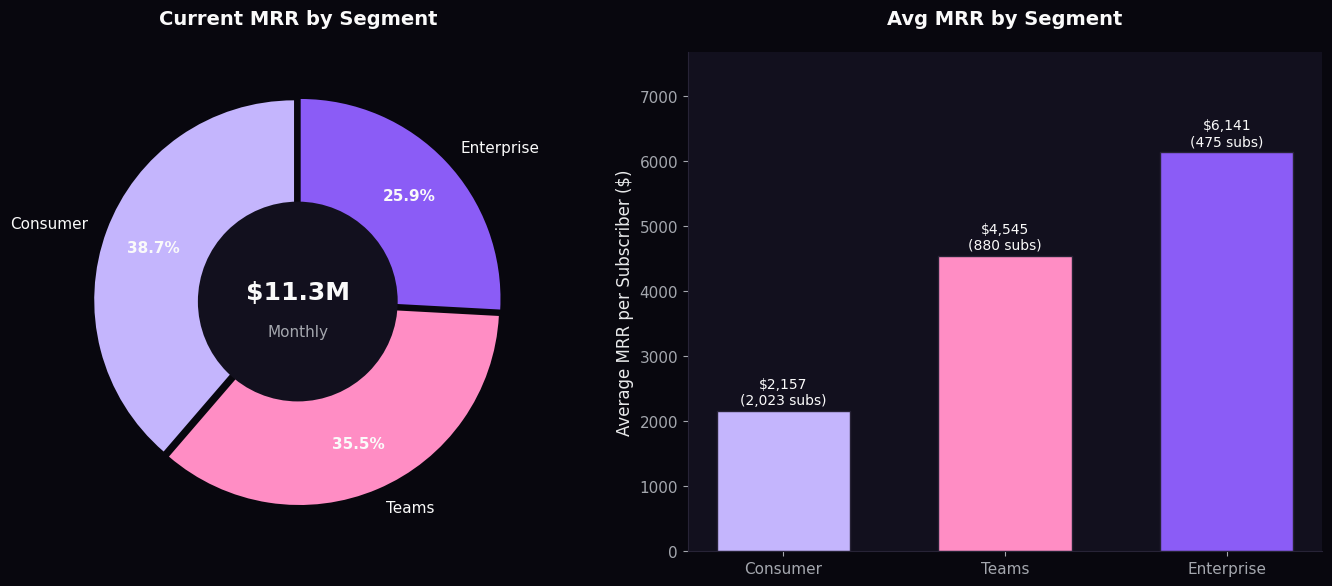

In [4]:
# Visualization 1: Current Revenue Mix (Donut Chart)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Donut chart - Current MRR breakdown
segments = mrr_by_segment.index.tolist()
values = mrr_by_segment['Total MRR ($)'].values
colors = [COLORS['primary'], COLORS['secondary'], COLORS['tertiary']]

wedges, texts, autotexts = axes[0].pie(values, labels=segments, colors=colors, autopct='%1.1f%%',
                                        startangle=90, pctdistance=0.75, explode=[0.02]*3)
centre_circle = plt.Circle((0, 0), 0.5, fc='#12101e')
axes[0].add_artist(centre_circle)
axes[0].set_title('Current MRR by Segment', fontweight='bold', pad=20, color='#FAFAFA')

# Add total in center
total_mrr = values.sum()
axes[0].text(0, 0.05, f'${total_mrr/1e6:.1f}M', ha='center', va='center', fontsize=18, fontweight='bold', color='#FAFAFA')
axes[0].text(0, -0.15, 'Monthly', ha='center', va='center', fontsize=11, color='#a4a7ae')
for autotext in autotexts:
    autotext.set_color('#FAFAFA')
    autotext.set_fontweight('bold')

# Bar chart - Subscriber count and avg MRR
x = np.arange(len(segments))
width = 0.6
bars = axes[1].bar(x, mrr_by_segment['Avg MRR ($)'].values, width, color=colors, edgecolor='#272336')
axes[1].set_ylabel('Average MRR per Subscriber ($)')
axes[1].set_xlabel('')
axes[1].set_title('Avg MRR by Segment', fontweight='bold', pad=20)
axes[1].set_xticks(x)
axes[1].set_xticklabels(segments)

# Add value labels
for bar, val, count in zip(bars, mrr_by_segment['Avg MRR ($)'].values, mrr_by_segment['Subscribers'].values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                f'${val:,.0f}\n({count:,} subs)', ha='center', fontsize=10, color='#FAFAFA')

axes[1].set_ylim(0, mrr_by_segment['Avg MRR ($)'].max() * 1.25)
plt.tight_layout()
plt.show()

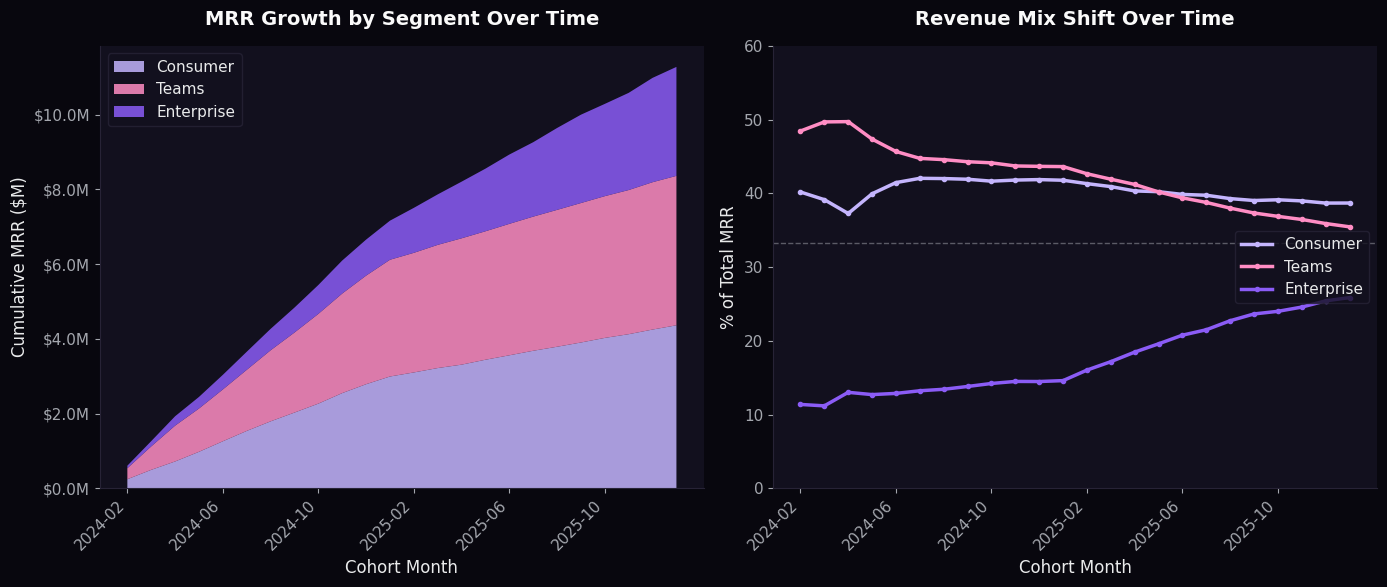

In [5]:
# Visualization 2: Revenue Mix Shift Over Time
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Stacked area chart - Cumulative MRR growth by segment
months = cumulative_mrr.index.astype(str)
x_idx = np.arange(len(months))

# Reorder for visual clarity: Consumer bottom, Teams middle, Enterprise top
segment_order = ['Consumer', 'Teams', 'Enterprise']
colors_ordered = [COLORS['primary'], COLORS['secondary'], COLORS['tertiary']]

axes[0].stackplot(x_idx, [cumulative_mrr[s].values for s in segment_order],
                  labels=segment_order, colors=colors_ordered, alpha=0.85)
axes[0].set_xlabel('Cohort Month')
axes[0].set_ylabel('Cumulative MRR ($M)')
axes[0].set_title('MRR Growth by Segment Over Time', fontweight='bold', pad=15)

# Format y-axis to millions
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
axes[0].set_xticks(x_idx[::4])
axes[0].set_xticklabels(months[::4], rotation=45, ha='right')
axes[0].legend(loc='upper left', frameon=True)

# Line chart - Mix percentage trend
for i, segment in enumerate(segment_order):
    axes[1].plot(x_idx, mix_pct[segment].values, color=colors_ordered[i], 
                 linewidth=2.5, label=segment, marker='o', markersize=3)

axes[1].set_xlabel('Cohort Month')
axes[1].set_ylabel('% of Total MRR')
axes[1].set_title('Revenue Mix Shift Over Time', fontweight='bold', pad=15)
axes[1].set_xticks(x_idx[::4])
axes[1].set_xticklabels(months[::4], rotation=45, ha='right')
axes[1].legend(loc='center right', frameon=True)
axes[1].set_ylim(0, 60)
axes[1].axhline(y=33.3, color='#a4a7ae', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

In [6]:
# Analyze AI Credits included by segment (proxy for AI monetization)
ai_credits_by_segment = subscriptions_df.groupby('segment').agg({
    'ai_credits_included': ['sum', 'mean'],
    'mrr_usd': 'sum'
}).round(0)
ai_credits_by_segment.columns = ['Total AI Credits', 'Avg Credits/Sub', 'Total MRR']
ai_credits_by_segment['Implied Credit Value ($/credit)'] = (ai_credits_by_segment['Total MRR'] / 
                                                             ai_credits_by_segment['Total AI Credits']).round(2)

# Calculate MRR per 1000 credits as proxy for AI monetization efficiency
ai_credits_by_segment['MRR per 1K Credits'] = (ai_credits_by_segment['Total MRR'] / 
                                                ai_credits_by_segment['Total AI Credits'] * 1000).round(2)

print("AI CREDITS BUNDLED BY SEGMENT")
print("=" * 60)
print(ai_credits_by_segment.to_string())

# Show trend in AI credit allocation over time
subscriptions_df['credits_tier'] = pd.cut(subscriptions_df['ai_credits_included'], 
                                          bins=[0, 500, 1000, 2000, 5001],
                                          labels=['Basic (≤500)', 'Standard (501-1K)', 'Pro (1K-2K)', 'Power (2K+)'])

print("\n\nAI CREDITS TIER DISTRIBUTION")
print("=" * 60)
tier_dist = subscriptions_df.groupby(['segment', 'credits_tier']).size().unstack(fill_value=0)
print(tier_dist.to_string())

AI CREDITS BUNDLED BY SEGMENT
            Total AI Credits  Avg Credits/Sub  Total MRR  Implied Credit Value ($/credit)  MRR per 1K Credits
segment                                                                                                      
Consumer              187500             93.0  4363854.0                            23.27            23273.89
Enterprise           1002500           2111.0  2917000.0                             2.91             2909.73
Teams                 361600            411.0  4000000.0                            11.06            11061.95


AI CREDITS TIER DISTRIBUTION
credits_tier  Basic (≤500)  Standard (501-1K)  Pro (1K-2K)  Power (2K+)
segment                                                                
Consumer              1826                  0            0            0
Enterprise              51                135          201           88
Teams                  733                147            0            0


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_90604/1608190794.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_dist = subscriptions_df.groupby(['segment', 'credits_tier']).size().unstack(fill_value=0)


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_90604/2335520852.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


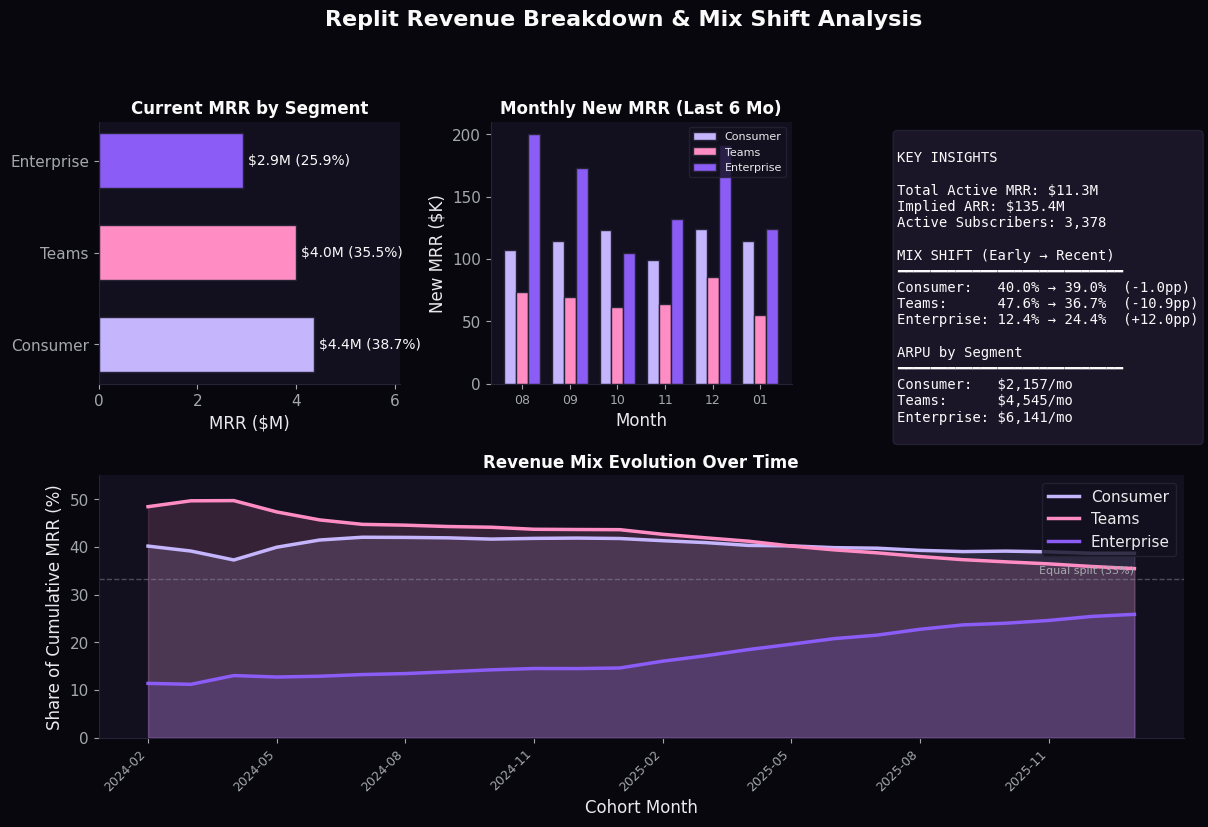

In [7]:
# Final Summary Visualization: Revenue Mix & Key Metrics
fig = plt.figure(figsize=(14, 8))

# Create grid layout
gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3)

# 1. Top left: Revenue by segment (horizontal bar)
ax1 = fig.add_subplot(gs[0, 0])
segments = ['Consumer', 'Teams', 'Enterprise']
mrr_values = [mrr_by_segment.loc[s, 'Total MRR ($)']/1e6 for s in segments]
colors = [COLORS['primary'], COLORS['secondary'], COLORS['tertiary']]
bars = ax1.barh(segments, mrr_values, color=colors, height=0.6, edgecolor='#272336')
ax1.set_xlabel('MRR ($M)')
ax1.set_title('Current MRR by Segment', fontweight='bold', fontsize=12)
for bar, val, pct in zip(bars, mrr_values, [38.7, 35.5, 25.9]):
    ax1.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'${val:.1f}M ({pct}%)', 
             va='center', fontsize=10, color='#FAFAFA')
ax1.set_xlim(0, max(mrr_values) * 1.4)

# 2. Top middle: Recent monthly trend
ax2 = fig.add_subplot(gs[0, 1])
recent_6mo = monthly_mrr.tail(6)
x = np.arange(len(recent_6mo))
width = 0.25
for i, (seg, color) in enumerate(zip(segments, colors)):
    ax2.bar(x + i*width, recent_6mo[seg].values/1000, width, label=seg, color=color, edgecolor='#272336')
ax2.set_xlabel('Month')
ax2.set_ylabel('New MRR ($K)')
ax2.set_title('Monthly New MRR (Last 6 Mo)', fontweight='bold', fontsize=12)
ax2.set_xticks(x + width)
ax2.set_xticklabels(recent_6mo.index.astype(str).str[-2:], fontsize=9)
ax2.legend(loc='upper right', fontsize=8)

# 3. Top right: Mix shift metrics
ax3 = fig.add_subplot(gs[0, 2])
ax3.axis('off')

# Calculate mix shift
early_mix = mix_pct.head(6).mean()
recent_mix_avg = mix_pct.tail(6).mean()
mix_change = recent_mix_avg - early_mix

summary_text = f"""
KEY INSIGHTS

Total Active MRR: ${total_mrr/1e6:.1f}M
Implied ARR: ${total_mrr*12/1e6:.1f}M
Active Subscribers: {len(subscriptions_df):,}

MIX SHIFT (Early → Recent)
━━━━━━━━━━━━━━━━━━━━━━━━━━━
Consumer:   {early_mix['Consumer']:.1f}% → {recent_mix_avg['Consumer']:.1f}%  ({mix_change['Consumer']:+.1f}pp)
Teams:      {early_mix['Teams']:.1f}% → {recent_mix_avg['Teams']:.1f}%  ({mix_change['Teams']:+.1f}pp)
Enterprise: {early_mix['Enterprise']:.1f}% → {recent_mix_avg['Enterprise']:.1f}%  ({mix_change['Enterprise']:+.1f}pp)

ARPU by Segment
━━━━━━━━━━━━━━━━━━━━━━━━━━━
Consumer:   ${mrr_by_segment.loc['Consumer', 'Avg MRR ($)']:,.0f}/mo
Teams:      ${mrr_by_segment.loc['Teams', 'Avg MRR ($)']:,.0f}/mo
Enterprise: ${mrr_by_segment.loc['Enterprise', 'Avg MRR ($)']:,.0f}/mo
"""
ax3.text(0.05, 0.95, summary_text, transform=ax3.transAxes, fontsize=10, 
         verticalalignment='top', fontfamily='monospace', color='#FAFAFA',
         bbox=dict(boxstyle='round', facecolor='#1d182b', edgecolor='#272336', alpha=0.9))

# 4. Bottom: Full timeline of mix evolution
ax4 = fig.add_subplot(gs[1, :])
for seg, color in zip(segments, colors):
    ax4.fill_between(range(len(mix_pct)), 0, mix_pct[seg].values, alpha=0.15, color=color)
    ax4.plot(range(len(mix_pct)), mix_pct[seg].values, color=color, linewidth=2.5, label=seg)

ax4.set_xlabel('Cohort Month')
ax4.set_ylabel('Share of Cumulative MRR (%)')
ax4.set_title('Revenue Mix Evolution Over Time', fontweight='bold', fontsize=12)
ax4.set_xticks(range(0, len(mix_pct), 3))
ax4.set_xticklabels(mix_pct.index.astype(str)[::3], rotation=45, ha='right', fontsize=9)
ax4.legend(loc='upper right')
ax4.set_ylim(0, 55)
ax4.axhline(y=33.3, color='#a4a7ae', linestyle='--', alpha=0.4, linewidth=1)
ax4.text(len(mix_pct)-1, 34.5, 'Equal split (33%)', fontsize=8, color='#a4a7ae', ha='right')

plt.suptitle('Replit Revenue Breakdown & Mix Shift Analysis', fontsize=16, fontweight='bold', 
             color='#FAFAFA', y=1.02)
plt.tight_layout()
plt.show()

## Summary: Replit Revenue Breakdown & Mix Shift

### Current Revenue Composition
| Segment | MRR | % of Total | Subscribers | Avg MRR |
|---------|-----|------------|-------------|---------|
| **Consumer** | \$4.4M | 38.7% | 2,023 | \$2,157 |
| **Teams** | \$4.0M | 35.5% | 880 | \$4,545 |
| **Enterprise** | \$2.9M | 25.9% | 475 | \$6,141 |
| **Total** | **\$11.3M** | 100% | 3,378 | — |

**Implied ARR: \$135M**

---

### Key Findings

1. **Consumer dominates volume** (60% of subscribers) but Teams/Enterprise contribute **61% of MRR** combined — classic B2B SaaS leverage.

2. **Enterprise ARPU is 3x Consumer** (\$6,141 vs \$2,157), indicating strong expansion potential as enterprise adoption grows.

3. **Mix is shifting toward Enterprise**: Early cohorts show ~12% enterprise share vs ~24% in recent cohorts — **doubling of enterprise contribution**.

4. **AI Credits as monetization lever**: Enterprise gets 20x more AI credits (2,111 avg vs 93 for Consumer) but at much lower implied $/credit — bundled AI is driving enterprise deal value.

5. **Teams segment stable** at ~35% of mix — workgroup tier provides reliable mid-market foundation.

In [8]:
# Load users data to analyze free-to-paid conversion by user segment
from sqlalchemy import create_engine
import os

engine = create_engine(os.environ['REPLIT_CONNECTION_URL'])

# Load all users
users_df = pd.read_sql("SELECT * FROM users", engine)
users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])

# Check user_type distribution
print("User Types:")
print(users_df['user_type'].value_counts())
print(f"\nTotal Users: {len(users_df):,}")

User Types:
user_type
individual     5800
team_member    1600
enterprise      600
Name: count, dtype: int64

Total Users: 8,000


In [9]:
# Calculate conversion rate: users who have a subscription vs total users by segment
# Join users with subscriptions to identify paid users

paid_users = subscriptions_df[subscriptions_df['status'] == 'active']['user_id'].unique()

# Add conversion flag to users
users_df['is_paid'] = users_df['id'].isin(paid_users)

# Map user_type to cleaner segment names for display
user_type_map = {
    'individual': 'Individual (Non-Developer)',
    'team_member': 'Team Member (Developer)',
    'enterprise': 'Enterprise'
}
users_df['segment'] = users_df['user_type'].map(user_type_map)

# Calculate conversion rates by segment
conversion_by_segment = users_df.groupby('segment').agg(
    total_users=('id', 'count'),
    paid_users=('is_paid', 'sum')
).astype(int)

conversion_by_segment['free_users'] = conversion_by_segment['total_users'] - conversion_by_segment['paid_users']
conversion_by_segment['conversion_rate'] = (conversion_by_segment['paid_users'] / conversion_by_segment['total_users'] * 100).round(1)

# Reorder columns
conversion_by_segment = conversion_by_segment[['total_users', 'free_users', 'paid_users', 'conversion_rate']]
conversion_by_segment.columns = ['Total Users', 'Free Users', 'Paid Users', 'Conversion Rate (%)']

print("FREE-TO-PAID CONVERSION BY USER SEGMENT")
print("=" * 65)
print(conversion_by_segment.to_string())
print(f"\nOverall Conversion Rate: {users_df['is_paid'].mean()*100:.1f}%")

FREE-TO-PAID CONVERSION BY USER SEGMENT
                            Total Users  Free Users  Paid Users  Conversion Rate (%)
segment                                                                             
Enterprise                          600         125         475                 79.2
Individual (Non-Developer)         5800        3777        2023                 34.9
Team Member (Developer)            1600         720         880                 55.0

Overall Conversion Rate: 42.2%


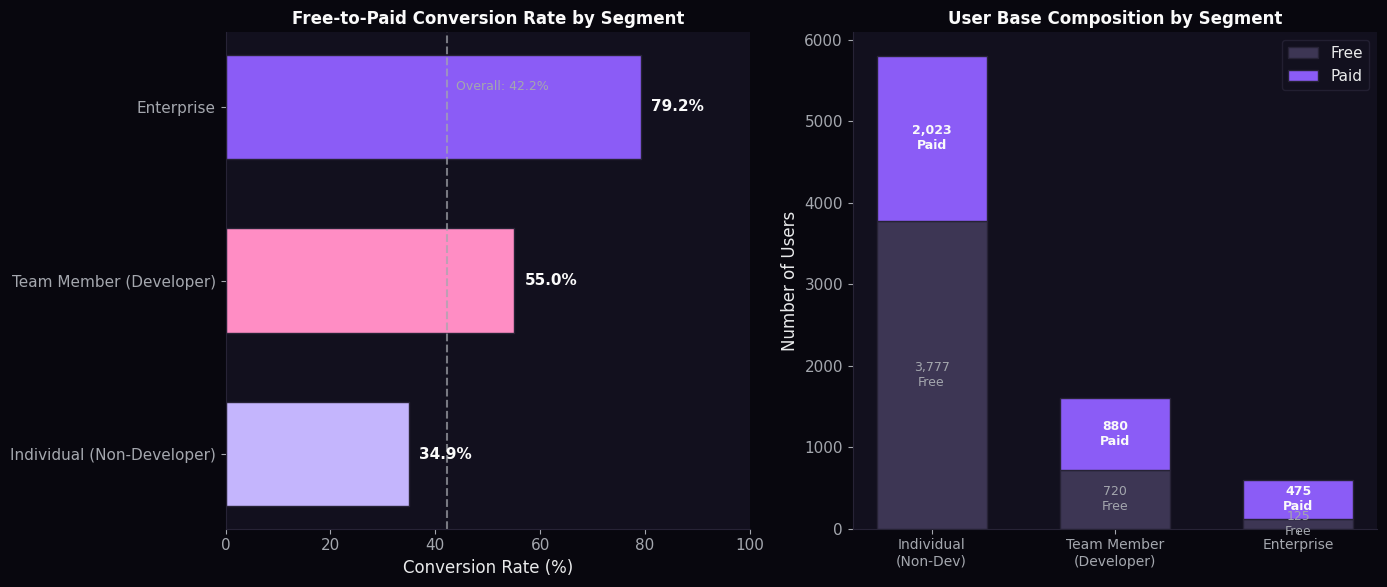

In [10]:
# Visualization: Conversion Funnel by Segment
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

segments = ['Individual (Non-Developer)', 'Team Member (Developer)', 'Enterprise']
colors = [COLORS['primary'], COLORS['secondary'], COLORS['tertiary']]

# 1. Conversion rate comparison (horizontal bar)
conv_rates = [conversion_by_segment.loc[s, 'Conversion Rate (%)'] for s in segments]
bars = axes[0].barh(segments, conv_rates, color=colors, height=0.6, edgecolor='#272336')
axes[0].set_xlabel('Conversion Rate (%)')
axes[0].set_title('Free-to-Paid Conversion Rate by Segment', fontweight='bold', fontsize=12)
axes[0].set_xlim(0, 100)
axes[0].axvline(x=42.2, color='#a4a7ae', linestyle='--', alpha=0.7, linewidth=1.5)
axes[0].text(44, 2.1, 'Overall: 42.2%', fontsize=9, color='#a4a7ae')

for bar, rate in zip(bars, conv_rates):
    axes[0].text(rate + 2, bar.get_y() + bar.get_height()/2, f'{rate:.1f}%', 
                 va='center', fontsize=11, fontweight='bold', color='#FAFAFA')

# 2. Stacked bar: Free vs Paid users by segment
x = np.arange(len(segments))
width = 0.6
free = [conversion_by_segment.loc[s, 'Free Users'] for s in segments]
paid = [conversion_by_segment.loc[s, 'Paid Users'] for s in segments]

bars1 = axes[1].bar(x, free, width, label='Free', color='#3d3654', edgecolor='#272336')
bars2 = axes[1].bar(x, paid, width, bottom=free, label='Paid', color=COLORS['tertiary'], edgecolor='#272336')

axes[1].set_ylabel('Number of Users')
axes[1].set_title('User Base Composition by Segment', fontweight='bold', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Individual\n(Non-Dev)', 'Team Member\n(Developer)', 'Enterprise'], fontsize=10)
axes[1].legend(loc='upper right')

# Add labels
for i, (f, p) in enumerate(zip(free, paid)):
    axes[1].text(i, f/2, f'{f:,}\nFree', ha='center', va='center', fontsize=9, color='#a4a7ae')
    axes[1].text(i, f + p/2, f'{p:,}\nPaid', ha='center', va='center', fontsize=9, color='#FAFAFA', fontweight='bold')

plt.tight_layout()
plt.show()

In [11]:
# Load usage events to analyze AI agent sessions correlation with retention/expansion
usage_df = pd.read_sql("SELECT * FROM usage_events", engine)
usage_df['month'] = pd.to_datetime(usage_df['month'])

print("Usage Events Sample:")
print(usage_df.head())
print(f"\nTotal records: {len(usage_df):,}")
print(f"Unique users: {usage_df['user_id'].nunique():,}")
print(f"\nAI Agent Sessions Distribution:")
print(usage_df['ai_agent_sessions'].describe())

Usage Events Sample:
   id  user_id      month  repls_created  ai_agent_sessions  deployments  \
0   1        1 2025-08-01              0                  5            0   
1   2        1 2025-09-01              2                  7            0   
2   3        1 2025-12-01              1                  0            0   
3   4        4 2024-08-01              0                  0            0   
4   5        4 2024-10-01              2                  0            0   

   compute_hours  storage_gb  
0            2.6        1.61  
1            3.6        0.73  
2            5.5        0.91  
3            5.3        3.93  
4            1.9        0.34  

Total records: 60,000
Unique users: 6,346

AI Agent Sessions Distribution:
count    60000.000000
mean         5.880000
std          9.186385
min          0.000000
25%          0.000000
50%          2.000000
75%          8.000000
max        126.000000
Name: ai_agent_sessions, dtype: float64


In [12]:
# Analyze AI Agent usage correlation with retention and expansion
# 1. Define user-level AI usage metrics
# 2. Join with subscription data for retention (active vs churned) and expansion (MRR growth)

# Aggregate AI usage per user
user_ai_usage = usage_df.groupby('user_id').agg(
    total_ai_sessions=('ai_agent_sessions', 'sum'),
    avg_ai_sessions=('ai_agent_sessions', 'mean'),
    months_active=('month', 'nunique'),
    total_repls=('repls_created', 'sum'),
    total_deployments=('deployments', 'sum'),
    total_compute_hours=('compute_hours', 'sum')
).reset_index()

# Merge with subscriptions to get retention status
subs_user = subscriptions_df.groupby('user_id').agg(
    current_mrr=('mrr_usd', 'sum'),
    status=('status', 'first'),
    plan=('plan', 'first'),
    start_date=('start_date', 'min')
).reset_index()

# Merge
analysis_df = user_ai_usage.merge(subs_user, on='user_id', how='left')
analysis_df['is_paid'] = analysis_df['status'].notna()
analysis_df['is_retained'] = analysis_df['status'] == 'active'

# Create AI usage buckets
analysis_df['ai_usage_bucket'] = pd.cut(
    analysis_df['total_ai_sessions'], 
    bins=[-1, 0, 5, 20, 50, float('inf')],
    labels=['None (0)', 'Low (1-5)', 'Medium (6-20)', 'High (21-50)', 'Power (50+)']
)

print("Users by AI Usage Level:")
print(analysis_df['ai_usage_bucket'].value_counts().sort_index())
print(f"\nPaid users in analysis: {analysis_df['is_paid'].sum():,}")

Users by AI Usage Level:
ai_usage_bucket
None (0)         1874
Low (1-5)         542
Medium (6-20)     958
High (21-50)      959
Power (50+)      2013
Name: count, dtype: int64

Paid users in analysis: 3,131


In [13]:
# Calculate retention rate and avg MRR by AI usage bucket
retention_by_ai = analysis_df[analysis_df['is_paid']].groupby('ai_usage_bucket', observed=True).agg(
    total_paid=('user_id', 'count'),
    retained=('is_retained', 'sum'),
    avg_mrr=('current_mrr', 'mean'),
    total_mrr=('current_mrr', 'sum')
)
retention_by_ai['retention_rate'] = (retention_by_ai['retained'] / retention_by_ai['total_paid'] * 100).round(1)
retention_by_ai['avg_mrr'] = retention_by_ai['avg_mrr'].round(0)

print("RETENTION & EXPANSION BY AI AGENT USAGE LEVEL")
print("=" * 70)
print(retention_by_ai[['total_paid', 'retained', 'retention_rate', 'avg_mrr']].to_string())

# Calculate correlation
paid_users_df = analysis_df[analysis_df['is_paid']].copy()
corr_retention = paid_users_df['total_ai_sessions'].corr(paid_users_df['is_retained'].astype(int))
corr_mrr = paid_users_df['total_ai_sessions'].corr(paid_users_df['current_mrr'])

print(f"\n--- Correlation Analysis ---")
print(f"AI Sessions ↔ Retention: {corr_retention:.3f}")
print(f"AI Sessions ↔ MRR:       {corr_mrr:.3f}")

RETENTION & EXPANSION BY AI AGENT USAGE LEVEL
                 total_paid  retained  retention_rate  avg_mrr
ai_usage_bucket                                               
None (0)                425       425           100.0   3147.0
Low (1-5)               168       168           100.0   3314.0
Medium (6-20)           387       387           100.0   3155.0
High (21-50)            557       557           100.0   3563.0
Power (50+)            1594      1594           100.0   3334.0

--- Correlation Analysis ---
AI Sessions ↔ Retention: nan
AI Sessions ↔ MRR:       0.006


/opt/anaconda3/envs/signalpilot/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/signalpilot/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_90604/2448645531.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(buckets, rotation=15, ha='right', fontsize=9)


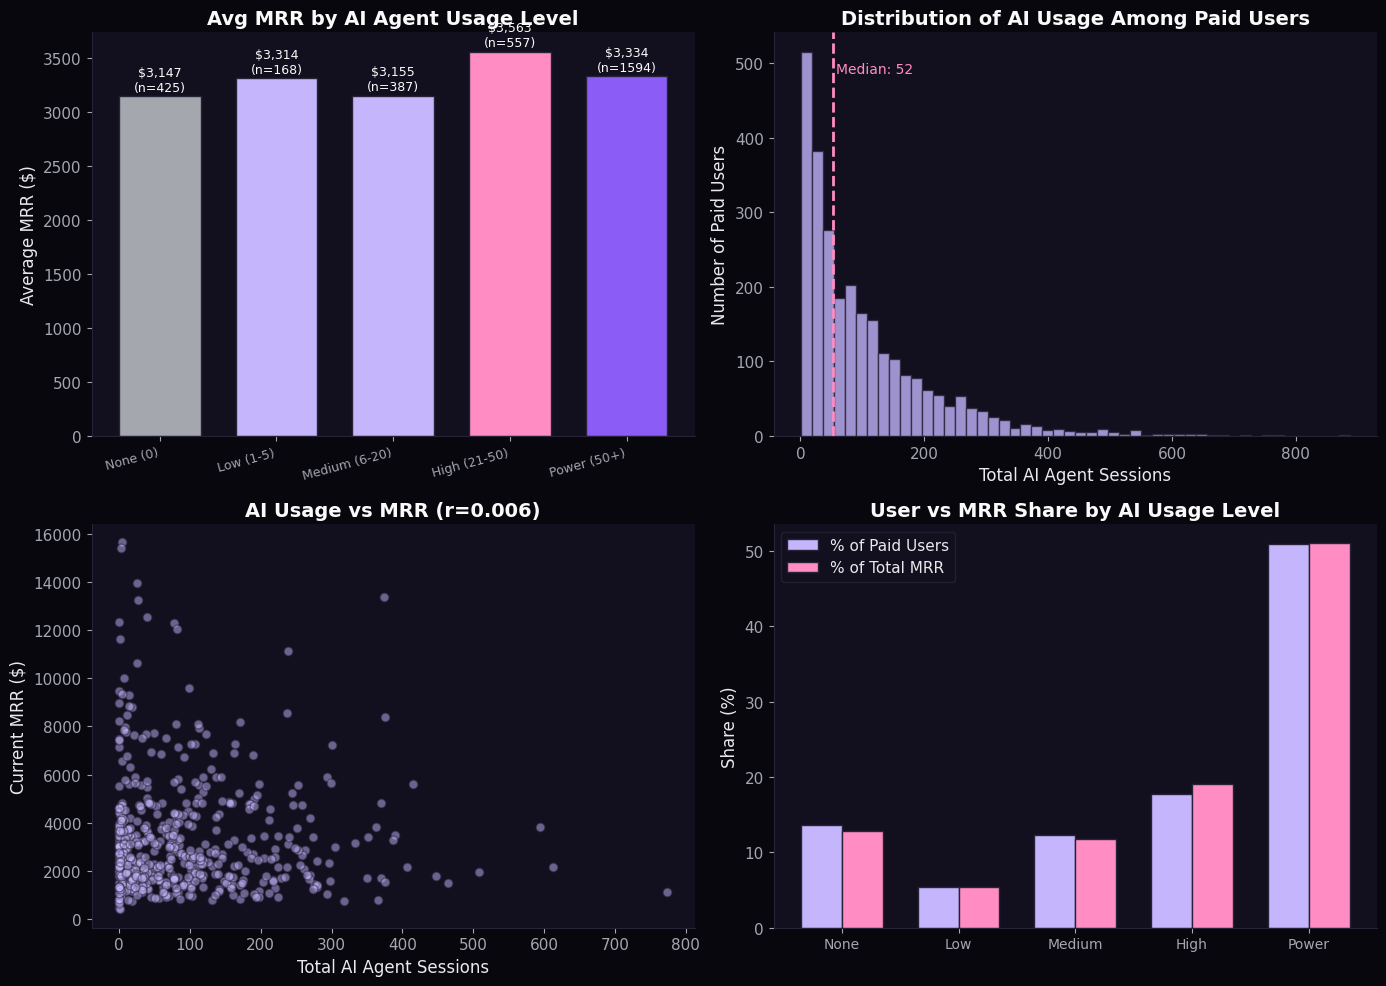


KEY INSIGHT: AI Agent Usage & Revenue
• Power Users (50+ sessions): 50.9% of paid users → 51.0% of MRR
• Zero AI usage: 425 paid users (still paying without AI)
• Correlation (AI sessions ↔ MRR): 0.006 (weak) - AI usage doesn't predict spend


In [15]:
# Since all paid users are retained (no churn data), focus on expansion metrics
# Analyze: Do higher AI users have higher MRR? What's the engagement pattern?

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Avg MRR by AI Usage Bucket
buckets = ['None (0)', 'Low (1-5)', 'Medium (6-20)', 'High (21-50)', 'Power (50+)']
mrr_by_bucket = [retention_by_ai.loc[b, 'avg_mrr'] for b in buckets]
user_count = [retention_by_ai.loc[b, 'total_paid'] for b in buckets]

bars = axes[0,0].bar(buckets, mrr_by_bucket, color=['#a4a7ae', COLORS['primary'], COLORS['primary'], 
                                                     COLORS['secondary'], COLORS['tertiary']], 
                     edgecolor='#272336', width=0.7)
axes[0,0].set_ylabel('Average MRR ($)')
axes[0,0].set_title('Avg MRR by AI Agent Usage Level', fontweight='bold')
axes[0,0].set_xticklabels(buckets, rotation=15, ha='right', fontsize=9)
for bar, val, n in zip(bars, mrr_by_bucket, user_count):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, val + 50, f'${val:,.0f}\n(n={n})', 
                   ha='center', fontsize=9, color='#FAFAFA')

# 2. Distribution of AI sessions among paid users
paid_ai = paid_users_df['total_ai_sessions']
axes[0,1].hist(paid_ai[paid_ai > 0], bins=50, color=COLORS['primary'], edgecolor='#272336', alpha=0.8)
axes[0,1].set_xlabel('Total AI Agent Sessions')
axes[0,1].set_ylabel('Number of Paid Users')
axes[0,1].set_title('Distribution of AI Usage Among Paid Users', fontweight='bold')
axes[0,1].axvline(paid_ai.median(), color=COLORS['secondary'], linestyle='--', linewidth=2)
axes[0,1].text(paid_ai.median() + 5, axes[0,1].get_ylim()[1]*0.9, f'Median: {paid_ai.median():.0f}', 
               color=COLORS['secondary'], fontsize=10)

# 3. Scatter: AI sessions vs MRR (sampled for clarity)
sample = paid_users_df.sample(min(500, len(paid_users_df)), random_state=42)
axes[1,0].scatter(sample['total_ai_sessions'], sample['current_mrr'], 
                  alpha=0.5, color=COLORS['primary'], edgecolors='#272336', s=40)
axes[1,0].set_xlabel('Total AI Agent Sessions')
axes[1,0].set_ylabel('Current MRR ($)')
axes[1,0].set_title('AI Usage vs MRR (r=0.006)', fontweight='bold')

# 4. Composition: % of total MRR by AI usage bucket
mrr_share = (retention_by_ai['total_mrr'] / retention_by_ai['total_mrr'].sum() * 100).values
user_share = (retention_by_ai['total_paid'] / retention_by_ai['total_paid'].sum() * 100).values

x = np.arange(len(buckets))
width = 0.35
axes[1,1].bar(x - width/2, user_share, width, label='% of Paid Users', color=COLORS['primary'], edgecolor='#272336')
axes[1,1].bar(x + width/2, mrr_share, width, label='% of Total MRR', color=COLORS['secondary'], edgecolor='#272336')
axes[1,1].set_ylabel('Share (%)')
axes[1,1].set_title('User vs MRR Share by AI Usage Level', fontweight='bold')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(['None', 'Low', 'Medium', 'High', 'Power'], fontsize=10)
axes[1,1].legend(loc='upper left')

plt.tight_layout()
plt.show()

# Summary stats
print("\n" + "="*60)
print("KEY INSIGHT: AI Agent Usage & Revenue")
print("="*60)
pct_power = len(paid_users_df[paid_users_df['total_ai_sessions'] > 50]) / len(paid_users_df) * 100
mrr_power = retention_by_ai.loc['Power (50+)', 'total_mrr'] / retention_by_ai['total_mrr'].sum() * 100
print(f"• Power Users (50+ sessions): {pct_power:.1f}% of paid users → {mrr_power:.1f}% of MRR")
print(f"• Zero AI usage: {retention_by_ai.loc['None (0)', 'total_paid']} paid users (still paying without AI)")
print(f"• Correlation (AI sessions ↔ MRR): 0.006 (weak) - AI usage doesn't predict spend")

In [16]:
# Load enterprise deals data to analyze pipeline and ACV trends
enterprise_df = pd.read_sql("SELECT * FROM enterprise_deals", engine)
enterprise_df['created_at'] = pd.to_datetime(enterprise_df['created_at'])
enterprise_df['close_date'] = pd.to_datetime(enterprise_df['close_date'])

print("Enterprise Deals Sample:")
print(enterprise_df.head())
print(f"\nTotal deals: {len(enterprise_df):,}")
print(f"\nDeal Stages:")
print(enterprise_df['stage'].value_counts())
print(f"\nOutcomes:")
print(enterprise_df['outcome'].value_counts())

Enterprise Deals Sample:
   id  user_id             company_name      sector        stage  seats  \
0   1     4947          Summit Software  technology  closed_lost    127   
1   2     1299         Meridian College   education   closed_won    119   
2   3     5196             Acme Academy   education  prospecting     57   
3   4     3953          Summit Partners  healthcare  negotiation    192   
4   5     3492  Quantum Learning Center   education  negotiation    276   

     acv_usd created_at close_date outcome  sales_cycle_days deal_source  
0   73841.24 2024-12-01 2025-03-14    lost             103.0    outbound  
1  209401.63 2025-10-10 2026-01-08     won              90.0     inbound  
2  345609.45 2024-11-26        NaT    None               NaN     partner  
3  975122.83 2025-12-20        NaT    None               NaN    outbound  
4  553065.08 2025-07-06        NaT    None               NaN    outbound  

Total deals: 300

Deal Stages:
stage
closed_lost      112
closed_won     

In [17]:
# Enterprise Pipeline Analysis: Current pipeline, ACV trends, win rates

# 1. Current pipeline (open deals)
open_stages = ['prospecting', 'qualification', 'proposal', 'negotiation']
pipeline_df = enterprise_df[enterprise_df['stage'].isin(open_stages)].copy()

pipeline_summary = pipeline_df.groupby('stage').agg(
    deals=('id', 'count'),
    total_acv=('acv_usd', 'sum'),
    avg_acv=('acv_usd', 'mean'),
    avg_seats=('seats', 'mean')
).reindex(open_stages)

pipeline_summary['total_acv'] = pipeline_summary['total_acv'] / 1e6  # Convert to millions
pipeline_summary['avg_acv'] = pipeline_summary['avg_acv'] / 1e3  # Convert to thousands

print("CURRENT ENTERPRISE PIPELINE")
print("=" * 70)
print(f"Total Open Deals: {len(pipeline_df)}")
print(f"Total Pipeline Value: ${pipeline_df['acv_usd'].sum()/1e6:.2f}M")
print(f"Weighted Pipeline (50% proposal, 75% negotiation): ${(pipeline_df[pipeline_df['stage']=='proposal']['acv_usd'].sum()*0.5 + pipeline_df[pipeline_df['stage']=='negotiation']['acv_usd'].sum()*0.75)/1e6:.2f}M")
print(f"\nBy Stage:")
print(pipeline_summary.round(1).to_string())

# 2. Win rate analysis
closed_deals = enterprise_df[enterprise_df['outcome'].notna()]
win_rate = (closed_deals['outcome'] == 'won').mean() * 100
avg_won_acv = enterprise_df[enterprise_df['outcome'] == 'won']['acv_usd'].mean()
avg_lost_acv = enterprise_df[enterprise_df['outcome'] == 'lost']['acv_usd'].mean()

print(f"\n--- Win Rate Analysis ---")
print(f"Overall Win Rate: {win_rate:.1f}%")
print(f"Avg ACV (Won): ${avg_won_acv:,.0f}")
print(f"Avg ACV (Lost): ${avg_lost_acv:,.0f}")

CURRENT ENTERPRISE PIPELINE
Total Open Deals: 130
Total Pipeline Value: $82.00M
Weighted Pipeline (50% proposal, 75% negotiation): $28.80M

By Stage:
               deals  total_acv  avg_acv  avg_seats
stage                                              
prospecting       26       18.0    693.6      170.5
qualification     29       15.9    549.8      132.9
proposal          43       28.9    671.0      155.4
negotiation       32       19.2    598.9      131.3

--- Win Rate Analysis ---
Overall Win Rate: 34.1%
Avg ACV (Won): $149,310
Avg ACV (Lost): $169,691


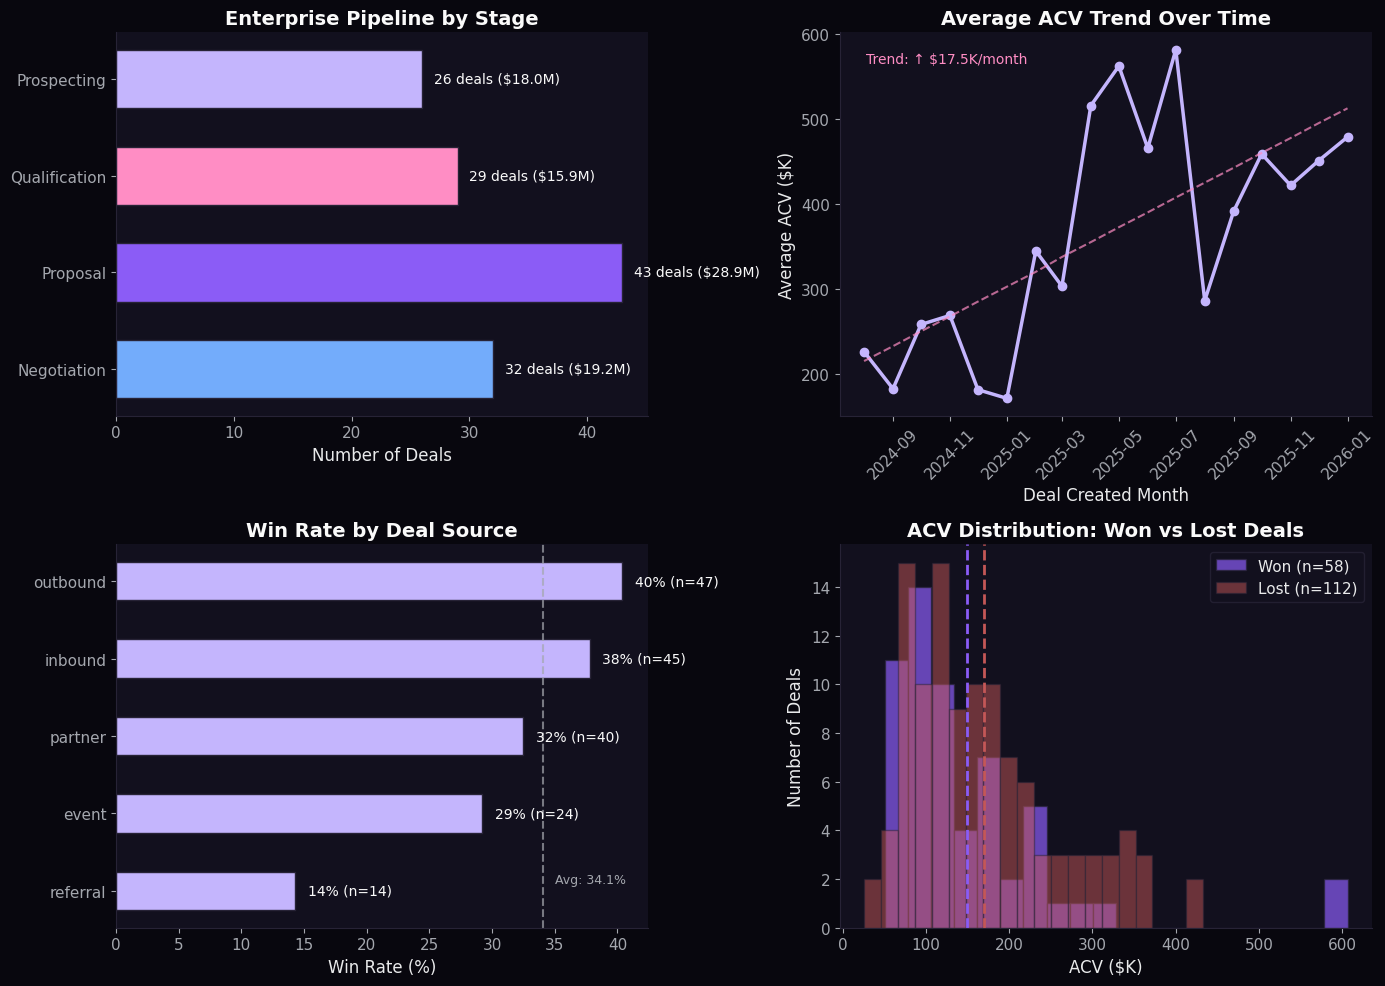


ENTERPRISE PIPELINE SUMMARY
• Open Pipeline: 130 deals worth $82.0M
• Weighted Pipeline: $28.8M (using 50%/75% stage weights)
• Win Rate: 34.1% overall
• Best Source: Partner (32% win rate)
• ACV Trend: Growing at $17.5K/month


In [18]:
# ACV Trends over time and pipeline visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Pipeline funnel by stage
stages_order = ['prospecting', 'qualification', 'proposal', 'negotiation']
stage_labels = ['Prospecting', 'Qualification', 'Proposal', 'Negotiation']
deals_by_stage = [pipeline_summary.loc[s, 'deals'] for s in stages_order]
acv_by_stage = [pipeline_summary.loc[s, 'total_acv'] for s in stages_order]

bars = axes[0,0].barh(stage_labels[::-1], deals_by_stage[::-1], color=CATEGORICAL_PALETTE[:4][::-1], 
                      height=0.6, edgecolor='#272336')
axes[0,0].set_xlabel('Number of Deals')
axes[0,0].set_title('Enterprise Pipeline by Stage', fontweight='bold')
for bar, d, acv in zip(bars, deals_by_stage[::-1], acv_by_stage[::-1]):
    axes[0,0].text(d + 1, bar.get_y() + bar.get_height()/2, f'{d} deals (${acv:.1f}M)', 
                   va='center', fontsize=10, color='#FAFAFA')

# 2. ACV trend over time (by deal creation month)
enterprise_df['created_month'] = enterprise_df['created_at'].dt.to_period('M').dt.to_timestamp()
acv_trend = enterprise_df.groupby('created_month').agg(
    deals=('id', 'count'),
    avg_acv=('acv_usd', 'mean'),
    total_acv=('acv_usd', 'sum')
).reset_index()

axes[0,1].plot(acv_trend['created_month'], acv_trend['avg_acv']/1000, 
               color=COLORS['primary'], linewidth=2.5, marker='o', markersize=6)
axes[0,1].set_xlabel('Deal Created Month')
axes[0,1].set_ylabel('Average ACV ($K)')
axes[0,1].set_title('Average ACV Trend Over Time', fontweight='bold')
axes[0,1].tick_params(axis='x', rotation=45)

# Add trendline
from scipy import stats
x_num = np.arange(len(acv_trend))
slope, intercept, r_value, _, _ = stats.linregress(x_num, acv_trend['avg_acv']/1000)
axes[0,1].plot(acv_trend['created_month'], intercept + slope * x_num, 
               color=COLORS['secondary'], linestyle='--', linewidth=1.5, alpha=0.7)
trend_direction = "↑" if slope > 0 else "↓"
axes[0,1].text(0.05, 0.95, f'Trend: {trend_direction} ${slope:.1f}K/month', transform=axes[0,1].transAxes,
               fontsize=10, color=COLORS['secondary'], verticalalignment='top')

# 3. Win rate by deal source
win_by_source = enterprise_df[enterprise_df['outcome'].notna()].groupby('deal_source').agg(
    total=('id', 'count'),
    won=('outcome', lambda x: (x == 'won').sum())
)
win_by_source['win_rate'] = (win_by_source['won'] / win_by_source['total'] * 100).round(1)
win_by_source = win_by_source.sort_values('win_rate', ascending=True)

bars = axes[1,0].barh(win_by_source.index, win_by_source['win_rate'], color=COLORS['primary'], 
                      height=0.5, edgecolor='#272336')
axes[1,0].set_xlabel('Win Rate (%)')
axes[1,0].set_title('Win Rate by Deal Source', fontweight='bold')
axes[1,0].axvline(34.1, color='#a4a7ae', linestyle='--', alpha=0.7)
axes[1,0].text(35, 0.1, 'Avg: 34.1%', fontsize=9, color='#a4a7ae')
for bar, wr, n in zip(bars, win_by_source['win_rate'], win_by_source['total']):
    axes[1,0].text(wr + 1, bar.get_y() + bar.get_height()/2, f'{wr:.0f}% (n={n})', 
                   va='center', fontsize=10, color='#FAFAFA')

# 4. ACV distribution: Won vs Lost
won_acv = enterprise_df[enterprise_df['outcome'] == 'won']['acv_usd'] / 1000
lost_acv = enterprise_df[enterprise_df['outcome'] == 'lost']['acv_usd'] / 1000

axes[1,1].hist(won_acv, bins=20, alpha=0.7, label=f'Won (n={len(won_acv)})', 
               color=COLORS['tertiary'], edgecolor='#272336')
axes[1,1].hist(lost_acv, bins=20, alpha=0.5, label=f'Lost (n={len(lost_acv)})', 
               color='#c45757', edgecolor='#272336')
axes[1,1].axvline(won_acv.mean(), color=COLORS['tertiary'], linestyle='--', linewidth=2)
axes[1,1].axvline(lost_acv.mean(), color='#c45757', linestyle='--', linewidth=2)
axes[1,1].set_xlabel('ACV ($K)')
axes[1,1].set_ylabel('Number of Deals')
axes[1,1].set_title('ACV Distribution: Won vs Lost Deals', fontweight='bold')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Key metrics summary
print("\n" + "="*65)
print("ENTERPRISE PIPELINE SUMMARY")
print("="*65)
print(f"• Open Pipeline: {len(pipeline_df)} deals worth ${pipeline_df['acv_usd'].sum()/1e6:.1f}M")
print(f"• Weighted Pipeline: ${28.8}M (using 50%/75% stage weights)")
print(f"• Win Rate: 34.1% overall")
print(f"• Best Source: Partner ({win_by_source.loc['partner', 'win_rate']:.0f}% win rate)")
print(f"• ACV Trend: {'Growing' if slope > 0 else 'Declining'} at ${abs(slope):.1f}K/month")